In [1]:
import onnxruntime as ort
import onnx
# from tensorflow.python.keras.models import load_model
# from tensorflow.python.keras import backend as K
# import tf2onnx
import numpy as np
import math

# Part 1: Load of the 3D-GAN on Python

In [2]:
# Load the existent neural network
onnx_model = onnx.load("Generator_3DGAN.onnx")
onnx.checker.check_model(onnx_model)

In [3]:
ort_session = ort.InferenceSession('Generator_3DGAN.onnx', providers=['CPUExecutionProvider'])

In [4]:
# Declare the input in numpy format
input_np = np.random.randn(1, 256).astype(np.float32)
input_np[0,0] = 3
# input_np[0,1] = 1.5707 # * math.pi / 180
input_np[0,1] = 1.5
print(input_np.shape)
print(input_np)

(1, 256)
[[ 3.00000000e+00  1.50000000e+00  1.50966823e-01  3.08987880e+00
   3.08840424e-01  1.11441359e-01  7.28437901e-01 -7.67520487e-01
  -1.08815491e+00  2.80597687e-01  2.84601837e-01 -3.04418355e-01
  -2.34801490e-02  1.62296087e-01  5.15273094e-01  2.40883008e-02
  -9.70117822e-02  6.03525303e-02 -5.80317736e-01  7.95617282e-01
  -9.43815827e-01 -6.94535375e-01  1.47132742e+00 -1.26433575e+00
   1.30118978e+00 -5.21242797e-01 -7.35620022e-01 -5.17331958e-01
  -9.24423695e-01  9.93350208e-01  3.93326342e-01  5.59659064e-01
  -5.84031194e-02 -1.44783890e+00 -1.51342377e-01  4.11097288e-01
  -1.00425100e+00  1.30765736e+00  1.01099521e-01  1.65276742e+00
   5.48176825e-01 -1.68650642e-01 -8.64221215e-01 -9.59870517e-01
   2.04319552e-01  1.30456078e+00 -3.42712700e-01 -1.04587185e+00
   6.01637699e-02  8.93151760e-02 -5.92805684e-01  1.07682478e+00
  -5.05720272e-05 -1.13081658e+00  1.86634445e+00 -4.78846848e-01
  -1.50083825e-01 -3.68248336e-02  2.13260841e+00  1.58684418e-01
 

In [5]:
# Convert the numpy input into onnxruntime input
input_ort = ort.OrtValue.ortvalue_from_numpy(input_np)
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name
print(input_name)
print(output_name)
print(ort_session.get_inputs()[0])
print(ort_session.get_outputs()[0])

input_1
sequential_1
NodeArg(name='input_1', type='tensor(float)', shape=['unk__83', 256])
NodeArg(name='sequential_1', type='tensor(float)', shape=['unk__84', 51, 51, 25, 1])


In [6]:
# Print some specific parameters
print("Device used: " + str(input_ort.device_name()))
print("Shape of the input: " + str(input_ort.shape()))
print("Data type: " + str(input_ort.data_type()))

Device used: cpu
Shape of the input: [1, 256]
Data type: tensor(float)


In [7]:
# Now run the ONNX network
outputs = ort_session.run(None, {input_name : input_ort})

In [8]:
outputs = np.array(outputs)
outputs = outputs.reshape(51, 51, 25)
# outputs = outputs**(1/0.85)
# outputs = outputs / 50
print(outputs.shape)

(51, 51, 25)


In [9]:
# Import now the libraries for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/tmp/ipykernel_36112/1269877238.py:12: RuntimeWarning: divide by zero encountered in log
  img = ax.scatter(x, y, z, c=np.log(E), cmap='Blues')


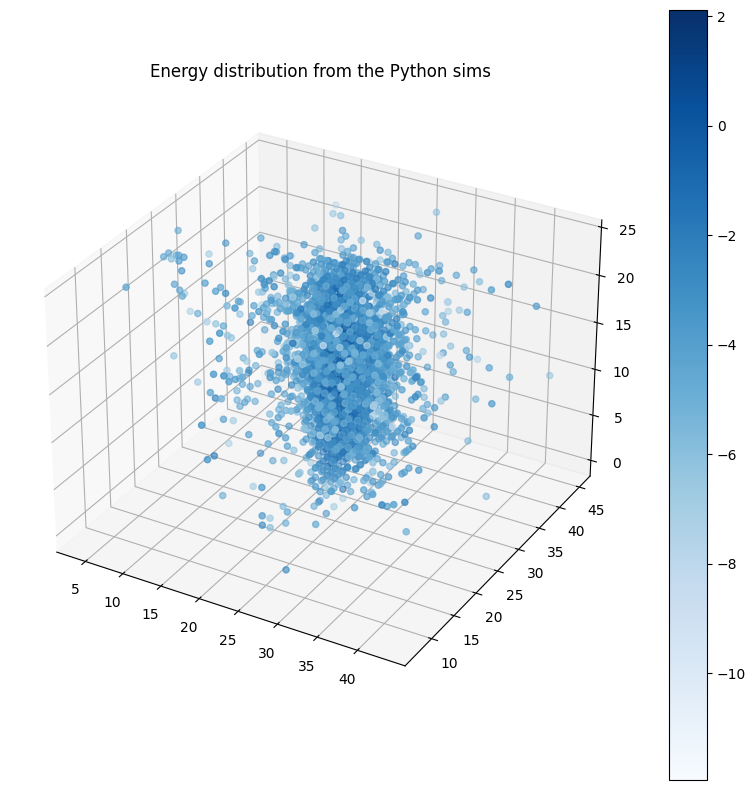

In [10]:
posns = np.indices((51, 51, 25))
x = posns[0].flatten()
y = posns[1].flatten()
z = posns[2].flatten()
E = outputs.flatten()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

plt.title("Energy distribution from the Python sims")

img = ax.scatter(x, y, z, c=np.log(E), cmap='Blues')
fig.colorbar(img)
plt.show()

In [11]:
# Load now the data from the file
data_fast_sims = np.loadtxt('FastSims.txt')

In [12]:
# Extract the energy and plot it as well
energy_fast_sims = data_fast_sims[:,0]
print(energy_fast_sims.size)

65025


/tmp/ipykernel_36112/2920503741.py:6: RuntimeWarning: divide by zero encountered in log
  img = ax.scatter(x, y, z, c=np.log(energy_fast_sims), cmap='Blues')


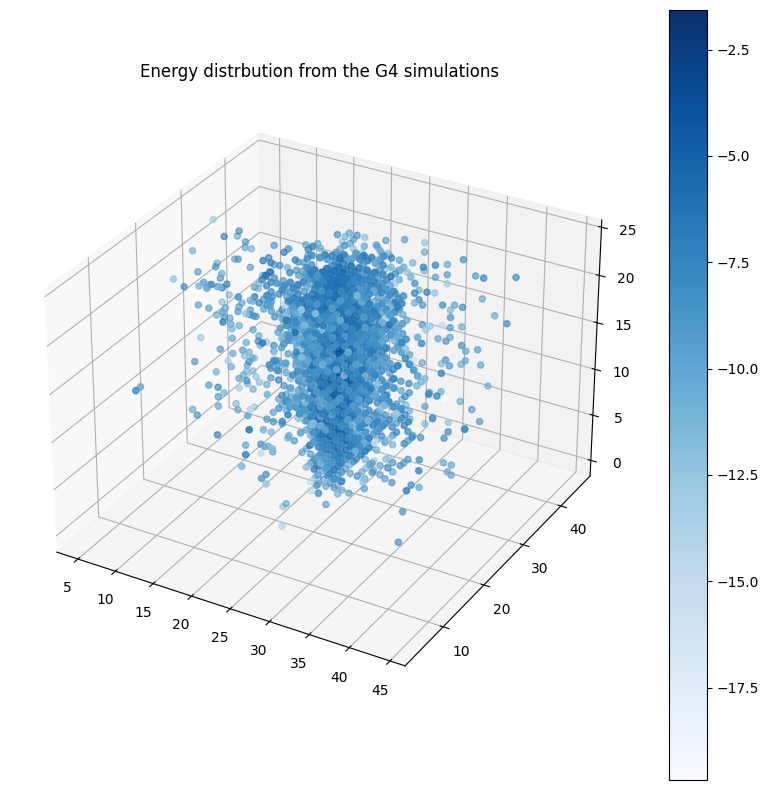

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

plt.title("Energy distrbution from the G4 simulations")

img = ax.scatter(x, y, z, c=np.log(energy_fast_sims), cmap='Blues')
fig.colorbar(img)
plt.show()

/tmp/ipykernel_36112/1414290566.py:9: RuntimeWarning: divide by zero encountered in log
  img = ax.scatter(x, y, z, c=np.log(E_model), cmap='Blues')


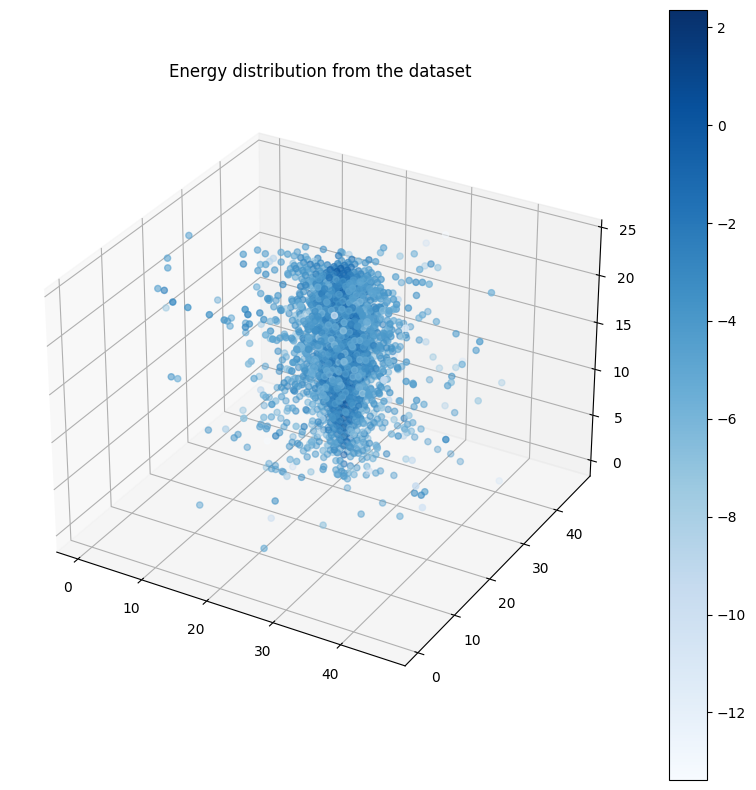

In [14]:
# Load the data model now
E_model = np.loadtxt("test.txt")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

plt.title("Energy distribution from the dataset")

img = ax.scatter(x, y, z, c=np.log(E_model), cmap='Blues')
fig.colorbar(img)
plt.show()

In [15]:
print("Energy sum from the G4 ONNX sims: " + str(np.sum(energy_fast_sims)))
print("Energy sum from Python sims: " + str(np.sum(E)))
print("Energy sum from the dataset: " + str(np.sum(E_model)))

Energy sum from the G4 ONNX sims: 5.88199561418518
Energy sum from Python sims: 295.75238
Energy sum from the dataset: 269.4729218048862


# Part 2: Reconstruction algorithm to the detector frame

/tmp/ipykernel_36112/2920503741.py:6: RuntimeWarning: divide by zero encountered in log
  img = ax.scatter(x, y, z, c=np.log(energy_fast_sims), cmap='Blues')


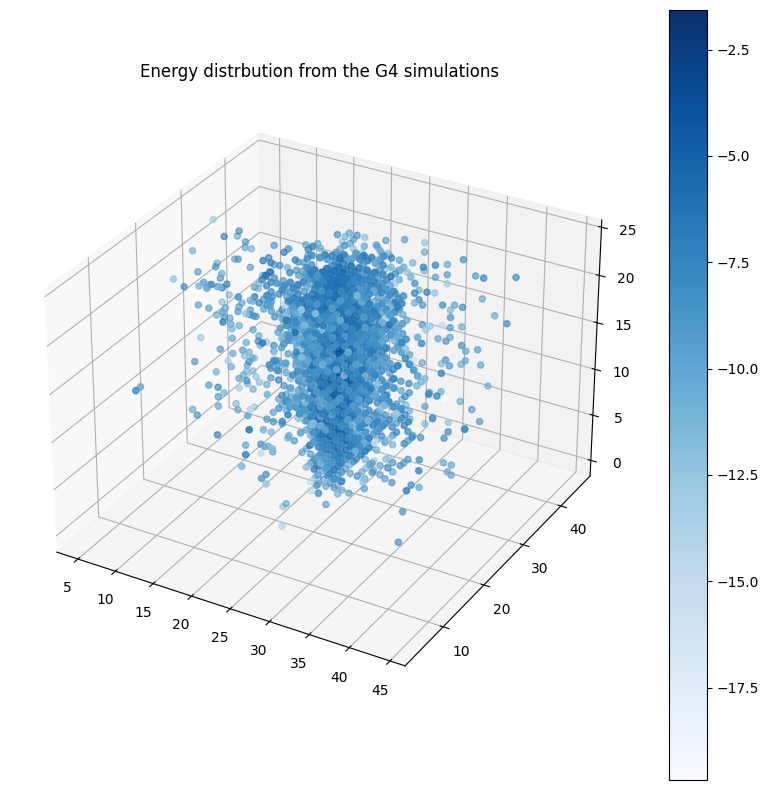

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

plt.title("Energy distrbution from the G4 simulations")

img = ax.scatter(x, y, z, c=np.log(energy_fast_sims), cmap='Blues')
fig.colorbar(img)
plt.show()

In [17]:
energy_fast_sims = energy_fast_sims.reshape(51,51,25)
print(energy_fast_sims[:,:,0].shape)
slice_zero = energy_fast_sims[:,:,0]

(51, 51)


/tmp/ipykernel_36112/3811918125.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(slice_zero), cmap='Blues')


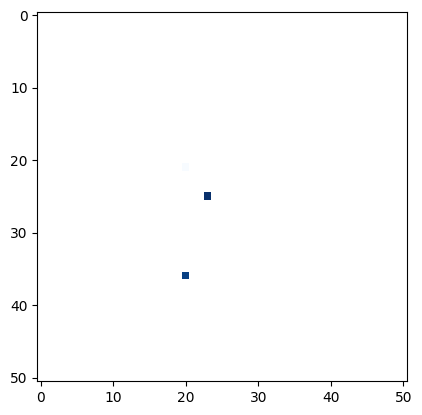

In [18]:
posns_2D = np.indices((51,51))
x_slice = posns_2D[0].flatten()
y_slice = posns_2D[1].flatten()
plt.imshow(np.log(slice_zero), cmap='Blues')

In [19]:
# Work out the coordinates of the barycenter in the zero-slice
x_bary = np.average(x_slice, weights=slice_zero.flatten())
y_bary = np.average(y_slice, weights=slice_zero.flatten())
print("x-coordinate of barycentre: " + str(x_bary))
print("y-coordinate of barycentre: " + str(y_bary))

x-coordinate of barycentre: 29.65300008837776
y-coordinate of barycentre: 21.70532803252984


## Dimensions of the layers within the EM Calorimeter

The first 17 layers have the thickness of $4.4 mm$, and the last 8 layers have the thickness of $6.8 mm$ each.

In [20]:
thickness_1 = 4.4
thickness_2 = 6.8

Add as well the input angle spatial parameters:

In [21]:
# Units of mm and radians are used - i.e: 1mm is represented as 1;
# 1m is represented as 1000, and 1 radian is represented as 1
y = 1500
theta = 1.5708
phi = 1.5708

# Get the radius vector according to the spherical polar coordinates
r = y / (np.sin(theta) * np.sin(phi))

# get the (x,y,z) global coordinates of the barycenter for the plane-zero
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

In [22]:
print(x)

-0.005509807655057031


In [23]:
print(slice_zero[int(x_bary)][int(y_bary)][0])
# plt.imshow(np.log(slice_zero), cmap='Blues')

IndexError: invalid index to scalar variable.

In [24]:
energy_fast_sims = data_fast_sims[:,0]
x_global = data_fast_sims[:,1]
y_global = data_fast_sims[:,2]
z_global = data_fast_sims[:,3]

/tmp/ipykernel_36112/2632640961.py:6: RuntimeWarning: divide by zero encountered in log
  img = ax.scatter(x_global, z_global, y_global, c=np.log(energy_fast_sims), cmap='Blues')


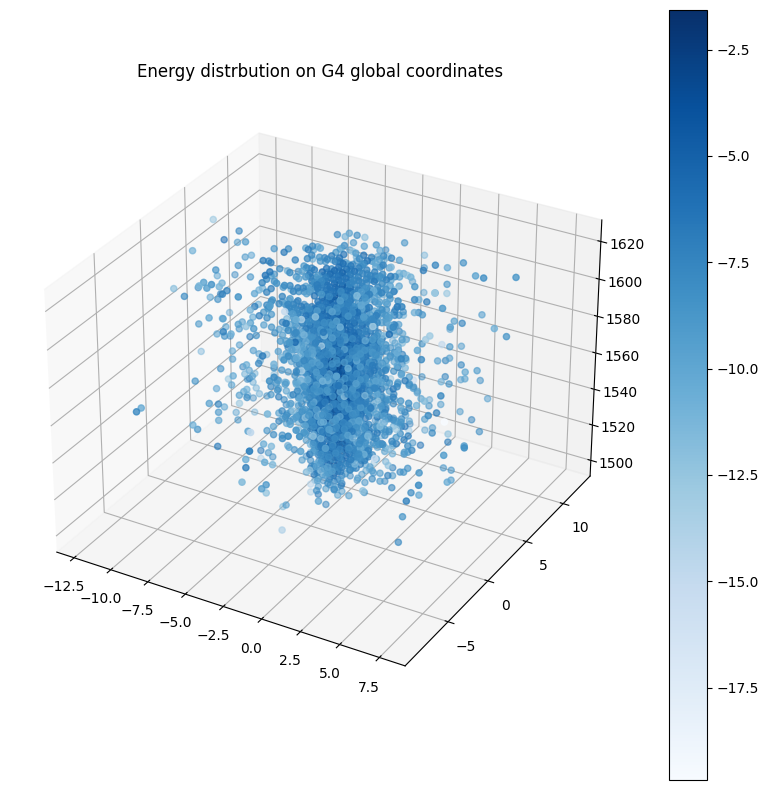

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

plt.title("Energy distrbution on G4 global coordinates")

img = ax.scatter(x_global, z_global, y_global, c=np.log(energy_fast_sims), cmap='Blues')
fig.colorbar(img)
plt.show()